In [91]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import datetime
import katpoint
import numpy as np
import time as time
import pandas as pd
import math
#import colorama
from colorama import Fore

We compute the rise and set time of the Sun for the given timestamps. This helps us to define the day and the night time. For the purpose of this script we are only interested in identifying the night time for every timestamps. We plot the LST against the date to show the rise and set of the Sun.

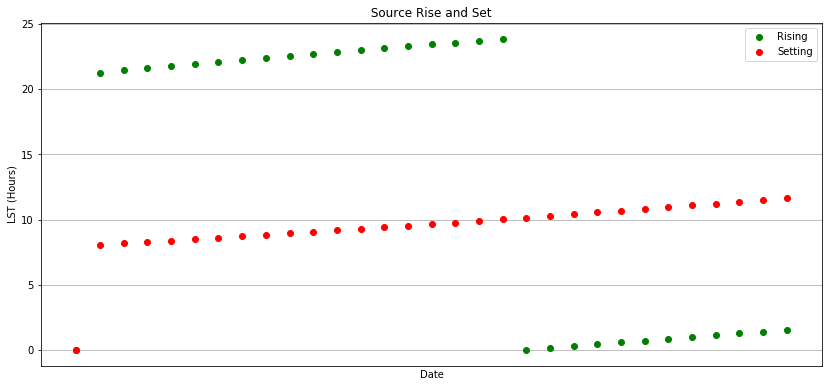

In [93]:

def rise_set(timestamp):
    site = katpoint.Antenna("m000, -30:42:39.8, 21:26:38.0, 1086.6, 13.5") # the site position using one antenna(m000)
    site.observer.date=katpoint.Timestamp(timestamp).to_ephem_date() # Set time
    site.observer.horizon='00:00:00.0' # Set horizon
    observer = site.observer 
    Sun = katpoint.Target("Sun,special")# Make sun object
    ephem_sun = Sun.body #Sun as an object
    ephem_sun.compute(observer) #compute for position of the observer
    return observer.next_rising(ephem_sun),observer.next_setting(ephem_sun)

site = katpoint.Antenna("m000, -30:42:39.8, 21:26:38.0, 1086.6, 13.5")
settime,risetime = np.zeros((31,2)),np.zeros((31,2))

for day in range(1, 31):

    #timestamp = katpoint.Timestamp() + 24*60*60*day
    time_ = dt.datetime(2023, 5, day,23,59,0)
    t = dt.datetime.timestamp(time_)
    if day == 1:
        timestamp = t
    else:
        timestamp = t + 24*60*60*day
    rise_time, set_time = rise_set(timestamp)
    risetime[day] = katpoint.Timestamp(rise_time), np.degrees(site.local_sidereal_time(rise_time))/15.
    settime[day] = katpoint.Timestamp(set_time), np.degrees(site.local_sidereal_time(set_time))/15.
    # Array values are unix time and decimal LST time in hours


fig = plt.figure(figsize=(14,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

dates=[dt.datetime.fromtimestamp(ts) for ts in risetime[:,0]]
plt.plot(risetime[:,1],'go',label="Rising")
dates2=[dt.datetime.fromtimestamp(ts) for ts in settime[:,0]]
plt.plot(settime[:,1],'ro',label="Setting")

plt.title(" Source Rise and Set ")
plt.ylabel('LST (Hours)')
plt.xlabel('Date')
plt.gcf().autofmt_xdate()
plt.grid()
plt.legend()


Identifying the night by taking the LST set and rise for each timestamp. 

In [94]:
def nighttime(riset,sett):
    'Arranging LST rise and set time to show night time '
    ind1 = 0
    ind2 = -1
       
    rt_new = np.delete(riset, ind1)
    st_new = np.delete(sett,ind2)
    setrise = {}
    for i in range(len(riset)-1):
        setrise[i] = [st_new[i],rt_new[i]]
    return setrise

Given csv file constaining observational information for observation schedule blocks, the function extract the night time observations only. 

In [95]:
def nightobs(filename, datefile):
    """Extracting only night time observations\
    from a given file of observational information
    
        Parmeters:
    -------------
    filename : csv file
        file containing all observations
    s_rise : float
        LST sun rise
    """
    
    ndates = []
    for j in range(len(datefile)):
        ndates.append(datefile[j].strftime('%Y-%m-%d'))
    data = pd.read_csv(filename)
    night_obs = data['night_obs']
    LST_starts = data['lst_start']
    LST_ends = data['lst_start_end']
    duration = data['simulated_duration']
    proposal_id = data['proposal_id']
    #proposal_id = sorted(proposal_id)
    ID = data['id']
    
    obs = {}
    for i in range(len(night_obs)):
        if night_obs[i] == 'Yes':
            obs[ID[i]] = [proposal_id[i],LST_starts[i],LST_ends[i],duration[i]]
    return obs,ndates

Pass a csv file in order to run parameter_extract function. This cell gives us LST start, end and duration of the observation in the same format. 

In [96]:
obs,date = nightobs('all_night_obs.csv', dates)
duration_ = []
LST_start = []
LST_end = []
obs_id = []
for i in obs.values():
    duration_.append(round(i[3]/3600,2))    
    g1 = i[1].replace(':', '.')
    f1 = float(g1)
    LST_start.append(f1)
    g2 = i[2].replace(':', '.') 
    f2 = float(g2)
    LST_end.append(f2)
    obs_id.append(i[0])

#duration_ = [item for item in duration_ if not(math.isnan(item)) == True] #removing nan
duration_ = [0 if math.isnan(x) else x for x in duration_]
#duration_.insert(-2,0)

print(LST_start[0])
print(LST_end[0])
print(duration_[0])
print(obs_id[0])
print(dates[0])

19.45
23.55
5.94
SCI-20220822-DP-01
1970-01-01 02:00:00


In [97]:
rt = risetime[:,1]
st = settime[:,1]
SetRise = nighttime(rt,st)

print(SetRise[0])
#SetRise.values()

[0.0, 21.210491822052514]


We check if the observation time range is within the LST night time range and color each observation by red if is not(cant run at that day due to both its LST start and end being outside of the night time zone), yellow if it is not(cant run at that day due to its LST end being outside of the range) and green if it is(can run at that day).

In [98]:
def obs_selection(s_set, s_rise, start_r, end_r, dur, observation_name):
    """ Check if the observation time range is within the LST time range.
    
    Parmeters:
    -------------
    s_set : float
        LST sun set
    s_rise : float
        LST sun rise
    start_r : float
        observation allowed start LST range
    end_r : float
        observation allowed end LST range
    dur : float 
        observation duration in hours
    """
    # check if observation start or end time is within the LST range
    cond1 = start_r >= s_set
    cond2 = end_r > s_set
    if  cond1 or cond2:
        if (cond1 and cond2) or cond1:
            start_time = start_r
            end_time = start_time + dur
        else:
            start_time = end_r
            end_time = start_time + dur
        if end_time > s_rise:
            return print(Fore.RED + '{} observation end time is outside the LST range'.format(observation_name))
        else:
            if end_time >= 24:
                end_time = end_time - 24
    else:
        return print(Fore.YELLOW + '{} both start and the end time are outside the LST range'.format(observation_name))
    
    
    return print(Fore.GREEN + 'Start time for {} is {} and end_time is {}'.format(observation_name, start_time, end_time))
    

In [99]:
ss = [i[0] for i in SetRise.values()] 
sr = [i[1] for i in SetRise.values()] 

for ind in range(len(ss)):
    print(Fore.BLUE + "Date : {} ------------------------------------------------".format(date[ind]))
    for ind2 in range(len(LST_start)):
        d = obs_selection(ss[ind], sr[ind], LST_start[ind2], LST_end[ind2], duration_[ind2], obs_id[ind2])

Date : 1970-01-01 ------------------------------------------------
SCI-20220822-DP-01 observation end time is outside the LST range
SCI-20220822-KK-01 observation end time is outside the LST range
Start time for SCI-20220822-CV-01 is 14.0 and end_time is 16.58
SCI-20220822-TJ-01 observation end time is outside the LST range
Start time for SCI-20220822-CV-01 is 14.0 and end_time is 16.63
SCI-20220822-RI-01 observation end time is outside the LST range
Start time for SCI-20220822-CV-01 is 9.0 and end_time is 11.61
Start time for SCI-20220822-CV-01 is 9.0 and end_time is 11.59
Start time for SCI-20220822-CV-01 is 9.0 and end_time is 11.59
Start time for SCI-20220822-AB-01 is 8.1 and end_time is 13.16
Start time for SCI-20220822-AB-01 is 8.1 and end_time is 13.16
Start time for SCI-20220822-AB-01 is 5.23 and end_time is 10.32
Start time for SCI-20220822-AB-01 is 5.23 and end_time is 10.32
Start time for SCI-20220822-MS-02 is 12.0 and end_time is 15.09
Start time for SCI-20220822-MS-02 is 1

Start time for SCI-20220822-IP-01 is 12.3 and end_time is 17.55
Start time for SCI-20220822-IP-01 is 10.0 and end_time is 15.3
Start time for SCI-20220822-IP-01 is 9.3 and end_time is 14.63
SCI-20220822-IP-01 both start and the end time are outside the LST range
SCI-20220822-IP-01 both start and the end time are outside the LST range
SCI-20220822-IP-01 both start and the end time are outside the LST range
SCI-20220822-AM-02 both start and the end time are outside the LST range
Start time for SCI-20220822-IP-01 is 11.4 and end_time is 16.96
Start time for SCI-20220822-IP-01 is 12.0 and end_time is 17.39
Start time for SCI-20220822-IP-01 is 12.0 and end_time is 17.25
Start time for SCI-20220822-IP-01 is 9.3 and end_time is 14.580000000000002
Start time for SCI-20220822-IP-01 is 9.3 and end_time is 14.600000000000001
SCI-20220822-IP-01 both start and the end time are outside the LST range
SCI-20220822-IP-01 both start and the end time are outside the LST range
Start time for SCI-20220822-

SCI-20220822-AW-01 observation end time is outside the LST range
SCI-20220822-AW-01 both start and the end time are outside the LST range
Date : 2023-06-16 ------------------------------------------------
SCI-20220822-DP-01 observation end time is outside the LST range
SCI-20220822-KK-01 observation end time is outside the LST range
SCI-20220822-CV-01 observation end time is outside the LST range
SCI-20220822-TJ-01 observation end time is outside the LST range
SCI-20220822-CV-01 observation end time is outside the LST range
SCI-20220822-RI-01 observation end time is outside the LST range
SCI-20220822-CV-01 observation end time is outside the LST range
SCI-20220822-CV-01 observation end time is outside the LST range
SCI-20220822-CV-01 observation end time is outside the LST range
SCI-20220822-AB-01 both start and the end time are outside the LST range
SCI-20220822-AB-01 both start and the end time are outside the LST range
SCI-20220822-AB-01 both start and the end time are outside the L